# <center>The Battle of Neighborhoods</center>

## 1. Data preparation
### 1. 1 Prepare population data
#### Total number of neighborhoods in Taipei City is 456.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import folium
import requests
from geopy.geocoders import Nominatim
%matplotlib inline
# UTF-8 transcoded raw data
data_path = './2021_Taipei_Borough_Population_1.csv'
raw_data_df = pd.read_csv(data_path, encoding='utf_8')
# Extract the latest dataset: 2021 Feb data
raw_data_df = raw_data_df[(raw_data_df['年份']==110) & (raw_data_df['月份']==2)]
# Drop unnecessary data:
# (a) 41 year-old and above data
# (b) year, month since it is all 2021 Feb data
# (c) Total
# (d) Neighborhood population by gender; only need neighborhood population subtotal
# compose age column name to be dropped
dropped_column = list(str(i)+'歲' for i in range(41, 100))+['年份','月份', '總計', '100歲以上']
raw_data_df.drop(columns=dropped_column, axis=1, inplace=True)
raw_data_df = raw_data_df.loc[raw_data_df['性別']=='計']
raw_data_df.drop(columns=['性別'], inplace=True)
# Rename columns
raw_data_df.rename(columns={"區域代碼": "ID", "區域別": "Neighborhood"}, inplace=True)
for i in range(0, 41):
    raw_data_df.rename(columns={str(i)+'歲': 'Age-'+str(i)}, inplace=True)
# Read neighborhood annual income data
income_df = pd.read_csv('./2017_Taipei_Neighborhood_Annual_Income.csv', encoding='utf_8')

id_array = raw_data_df['ID'].values
# Organize neighborhood values
tmp_borough_id = None
tmp_borough_name = None
for i in id_array:
    if((int(math.log10(i))+1)==8):
        tmp_borough_id = i
        tmp_borough_name = raw_data_df.loc[raw_data_df['ID']==i, ['Neighborhood']].values[0,0]
    else:
        k = raw_data_df.loc[raw_data_df['ID']==i, ['Neighborhood']].values[0,0] 
        s = k + ' ' + tmp_borough_name
        raw_data_df.loc[raw_data_df['ID']==i, 'Neighborhood'] = s

raw_data_df=raw_data_df.loc[raw_data_df['ID']>64000000]
# Reset index
raw_data_df.reset_index(drop=True, inplace=True)
raw_data_df

,ID,Neighborhood,Age-0,Age-1,Age-2,Age-3,Age-4,Age-5,Age-6,Age-7,...,Age-31,Age-32,Age-33,Age-34,Age-35,Age-36,Age-37,Age-38,Age-39,Age-40
0,63000010002,莊敬里 松山區,42,47,42,45,51,54,42,41,...,63,71,68,55,62,74,79,92,101,108
1,63000010003,東榮里 松山區,33,50,43,62,78,70,80,91,...,80,80,90,68,72,99,98,110,133,120
2,63000010004,三民里 松山區,36,53,64,58,69,65,65,69,...,64,83,54,64,85,103,79,104,107,115
3,63000010005,新益里 松山區,28,36,37,26,41,39,29,33,...,56,57,50,61,67,80,86,75,83,90
4,63000010006,富錦里 松山區,35,31,48,42,50,53,80,59,...,74,66,63,58,65,77,85,83,94,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,63000120038,關渡里 北投區,77,98,96,109,129,132,124,101,...,157,184,143,142,181,221,193,234,238,239
452,63000120039,泉源里 北投區,13,11,9,18,14,14,12,16,...,33,31,30,24,28,42,41,40,36,30
453,63000120040,湖山里 北投區,8,14,8,16,5,11,9,5,...,16,16,17,31,24,24,23,26,21,24
454,63000120041,大屯里 北投區,15,9,8,11,18,18,14,13,...,15,12,9,14,25,17,29,19,32,20


### 1.2 Prepare neighborhood annual income data
#### Datasource: 2017 Taipei City Neighborhood Income Tax Statistics (Unit in k NTD$)

In [2]:
# # Read neighborhood annual income data
income_df = pd.read_csv('./2017_Taipei_Neighborhood_Annual_Income.csv', encoding='utf_8')
columns = ['City','Borough','Neighborhood','Tax unit','Income','IncomeAvg','IncomeMedian','1stQ','3rdQ', 'Std', 'CC']
income_df.columns  =columns
income_df.drop(columns=['City','Tax unit'], inplace=True)
income_df = income_df.loc[(income_df['Neighborhood']!='總計') & (income_df['Neighborhood']!='合計') & (income_df['Neighborhood']!='其他')]
income_df.sort_values(by=['Borough','IncomeMedian'], ascending=False, inplace=True)
income_df['Neighborhood'] = income_df['Neighborhood'] + ' ' + income_df['Borough']
# Merge neighborhood annual income data with population data
income_df = income_df.merge(raw_data_df, left_on='Neighborhood', right_on='Neighborhood')
income_df.drop(columns=['ID'], inplace=True)
income_df.reset_index(inplace=True, drop=True)
income_df

,Borough,Neighborhood,Income,IncomeAvg,IncomeMedian,1stQ,3rdQ,Std,CC,Age-0,...,Age-31,Age-32,Age-33,Age-34,Age-35,Age-36,Age-37,Age-38,Age-39,Age-40
0,萬華區,西門里 萬華區,1258566,1013,701,366,1221,1538.38,151.81,23,...,38,50,33,53,56,64,54,83,71,67
1,萬華區,新起里 萬華區,2507677,1112,682,374,1302,2061.48,185.38,48,...,81,100,102,83,91,135,122,119,93,106
2,萬華區,全德里 萬華區,1480791,1064,682,383,1261,1987.25,186.81,24,...,51,56,71,55,61,66,64,85,93,86
3,萬華區,壽德里 萬華區,1521674,959,679,388,1215,978.40,102.04,38,...,58,60,61,60,64,80,75,86,77,85
4,萬華區,萬壽里 萬華區,1171107,1070,676,353,1261,1306.62,122.06,23,...,32,34,27,33,44,51,44,47,55,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,中山區,行政里 中山區,2061119,996,630,351,1200,2056.10,206.40,53,...,93,97,92,85,109,90,115,100,108,110
447,中山區,新庄里 中山區,1448754,880,619,355,1134,937.62,106.53,33,...,53,79,74,59,72,88,85,74,81,89
448,中山區,正義里 中山區,1927190,1067,618,328,1086,6565.49,615.60,32,...,72,74,60,64,82,92,95,104,88,100
449,中山區,聚盛里 中山區,1354314,954,607,343,1136,1349.87,141.43,27,...,60,44,50,54,69,67,67,81,81,78


### 1.3 Query Geopy for neighborhoods' latitude and longitude

In [3]:
geolocator = Nominatim(user_agent='capstone')
# city_country = ' Taipei Taiwan'
city_country = ' 台北市 台灣'
latitude_value = []
longitude_value = []
idx_array = income_df.index.values
for i in range(0, income_df.shape[0]):
    neighborhood = income_df.iloc[i, 1] + city_country
    location = geolocator.geocode(neighborhood)
    latitude_value.append(location.latitude)
    longitude_value.append(location.longitude)
# Add geospatial data
income_df.insert(2, 'Latitude', value=latitude_value)
income_df.insert(3, 'Longitude', value=longitude_value)
income_df

,Borough,Neighborhood,Latitude,Longitude,Income,IncomeAvg,IncomeMedian,1stQ,3rdQ,Std,...,Age-31,Age-32,Age-33,Age-34,Age-35,Age-36,Age-37,Age-38,Age-39,Age-40
0,萬華區,西門里 萬華區,25.042815,121.505472,1258566,1013,701,366,1221,1538.38,...,38,50,33,53,56,64,54,83,71,67
1,萬華區,新起里 萬華區,25.041003,121.505049,2507677,1112,682,374,1302,2061.48,...,81,100,102,83,91,135,122,119,93,106
2,萬華區,全德里 萬華區,25.023361,121.498731,1480791,1064,682,383,1261,1987.25,...,51,56,71,55,61,66,64,85,93,86
3,萬華區,壽德里 萬華區,25.023295,121.500671,1521674,959,679,388,1215,978.40,...,58,60,61,60,64,80,75,86,77,85
4,萬華區,萬壽里 萬華區,25.044793,121.505332,1171107,1070,676,353,1261,1306.62,...,32,34,27,33,44,51,44,47,55,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,中山區,行政里 中山區,25.065368,121.534927,2061119,996,630,351,1200,2056.10,...,93,97,92,85,109,90,115,100,108,110
447,中山區,新庄里 中山區,25.070702,121.530619,1448754,880,619,355,1134,937.62,...,53,79,74,59,72,88,85,74,81,89
448,中山區,正義里 中山區,25.050614,121.526592,1927190,1067,618,328,1086,6565.49,...,72,74,60,64,82,92,95,104,88,100
449,中山區,聚盛里 中山區,25.059172,121.525247,1354314,954,607,343,1136,1349.87,...,60,44,50,54,69,67,67,81,81,78


### 1.4 Aggregate population of 0 to 12 year-old kids and 25 to 40 year-old adults (as parents)
#### We focus on these two segments for business analysis. 

In [4]:
# 0 to 12 years old
kid_population = income_df.iloc[:, 11:24].sum(axis=1)
# 25 to 40 years old
parent_population = income_df.iloc[:, 36:].sum(axis=1)
income_df.insert(4, 'Kid', value=kid_population)
income_df.insert(5, 'Parent', value=parent_population)
income_df

,Borough,Neighborhood,Latitude,Longitude,Kid,Parent,Income,IncomeAvg,IncomeMedian,1stQ,...,Age-31,Age-32,Age-33,Age-34,Age-35,Age-36,Age-37,Age-38,Age-39,Age-40
0,萬華區,西門里 萬華區,25.042815,121.505472,343,770,1258566,1013,701,366,...,38,50,33,53,56,64,54,83,71,67
1,萬華區,新起里 萬華區,25.041003,121.505049,555,1506,2507677,1112,682,374,...,81,100,102,83,91,135,122,119,93,106
2,萬華區,全德里 萬華區,25.023361,121.498731,547,987,1480791,1064,682,383,...,51,56,71,55,61,66,64,85,93,86
3,萬華區,壽德里 萬華區,25.023295,121.500671,531,1116,1521674,959,679,388,...,58,60,61,60,64,80,75,86,77,85
4,萬華區,萬壽里 萬華區,25.044793,121.505332,253,576,1171107,1070,676,353,...,32,34,27,33,44,51,44,47,55,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,中山區,行政里 中山區,25.065368,121.534927,471,1491,2061119,996,630,351,...,93,97,92,85,109,90,115,100,108,110
447,中山區,新庄里 中山區,25.070702,121.530619,431,1141,1448754,880,619,355,...,53,79,74,59,72,88,85,74,81,89
448,中山區,正義里 中山區,25.050614,121.526592,442,1219,1927190,1067,618,328,...,72,74,60,64,82,92,95,104,88,100
449,中山區,聚盛里 中山區,25.059172,121.525247,300,909,1354314,954,607,343,...,60,44,50,54,69,67,67,81,81,78


### 1.5 Create Taipei City map and mark each neighborhood.

In [5]:
# Create a Taipei City map by using folium
taipei_location = geolocator.geocode('Taipei Taiwan')
map_taipei = folium.Map(location=[taipei_location.latitude, taipei_location.longitude], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(income_df['Latitude'], income_df['Longitude'], income_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_taipei)
map_taipei

### 1.6 To search local neighborhood venue through Foursquare API

In [1]:
# Foursquare connection information
CLIENT_ID = '' 
CLIENT_SECRET = ''
VERSION = '20210323' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [7]:
# function to get nearby venues in Food category
def getNearbyVenues(names, latitudes, longitudes, radius=500, categoryId='4d4b7105d754a06374d81259'):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, categoryId, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # add venue attributes
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
# Get neighborhoods venues with venue categories.
taipei_venues_df = getNearbyVenues(names=income_df['Neighborhood'],
                                   latitudes=income_df['Latitude'],
                                   longitudes=income_df['Longitude']
                                  )
taipei_venues_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,西門里 萬華區,25.042815,121.505472,ACME Breakfast CLUB,25.043211,121.506733,Breakfast Spot
1,西門里 萬華區,25.042815,121.505472,Starbucks Coffee (星巴克),25.043141,121.504920,Coffee Shop
2,西門里 萬華區,25.042815,121.505472,SOL bistro (SOL bistro 料理小酒館),25.041925,121.506239,Bistro
3,西門里 萬華區,25.042815,121.505472,McDonald's (麥當勞),25.044827,121.505363,Fast Food Restaurant
4,西門里 萬華區,25.042815,121.505472,Lao Shandong Homemade Noodles (老山東牛肉家常麵),25.043786,121.505832,Chinese Restaurant
...,...,...,...,...,...,...,...
19377,大佳里 中山區,25.072798,121.542440,Mary Jane's Pizza,25.074130,121.538730,Italian Restaurant
19378,大佳里 中山區,25.072798,121.542440,松山機場 P.r.o. Coffee,25.072244,121.543275,Café
19379,大佳里 中山區,25.072798,121.542440,Ln. 180,25.072117,121.538444,Café
19380,大佳里 中山區,25.072798,121.542440,美而美漢堡三明治,25.068148,121.539484,Breakfast Spot


In [9]:
taipei_venues_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,西門里 萬華區,25.042815,121.505472,ACME Breakfast CLUB,25.043211,121.506733,Breakfast Spot
1,西門里 萬華區,25.042815,121.505472,Starbucks Coffee (星巴克),25.043141,121.504920,Coffee Shop
2,西門里 萬華區,25.042815,121.505472,SOL bistro (SOL bistro 料理小酒館),25.041925,121.506239,Bistro
3,西門里 萬華區,25.042815,121.505472,McDonald's (麥當勞),25.044827,121.505363,Fast Food Restaurant
4,西門里 萬華區,25.042815,121.505472,Lao Shandong Homemade Noodles (老山東牛肉家常麵),25.043786,121.505832,Chinese Restaurant
...,...,...,...,...,...,...,...
19377,大佳里 中山區,25.072798,121.542440,Mary Jane's Pizza,25.074130,121.538730,Italian Restaurant
19378,大佳里 中山區,25.072798,121.542440,松山機場 P.r.o. Coffee,25.072244,121.543275,Café
19379,大佳里 中山區,25.072798,121.542440,Ln. 180,25.072117,121.538444,Café
19380,大佳里 中山區,25.072798,121.542440,美而美漢堡三明治,25.068148,121.539484,Breakfast Spot


### 1.7 Get overall business status of each neighborhood.

In [271]:
from sklearn.cluster import KMeans
neighborhood_array = income_df['Neighborhood'].values

dummy_df = pd.get_dummies(data=taipei_venues_df['Venue Category'], prefix='', prefix_sep='')
dummy_df.insert(0, column='Neighborhood', value=taipei_venues_df['Neighborhood'])
dummy_df
# Aggregate each neighborhood's restaurants by restaurant category 
dummy_df = dummy_df.groupby(by=['Neighborhood']).sum().reset_index()
# Aggregate each neighborhood's total restaurants
dummy_df['Restaurant Density'] = dummy_df.iloc[:, 1:].sum(axis=1)
# Reorder columns for better readability
cols = dummy_df.columns.tolist()
cols = cols[0:1] + cols[-1:] + cols[1:len(cols)-1]
dummy_df = dummy_df[cols]
dummy_df

,Neighborhood,Restaurant Density,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yunnan Restaurant,Zhejiang Restaurant
0,一德里 北投區,12,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,三張里 信義區,49,0,1,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2,三愛里 中正區,50,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,三民里 松山區,50,0,0,0,0,0,0,4,0,...,0,0,1,1,0,0,0,0,0,0
4,三犁里 信義區,49,0,0,0,0,0,0,2,0,...,0,0,0,5,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,龍福里 中正區,50,0,0,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,0,0
438,龍興里 中正區,50,0,0,0,0,0,0,2,0,...,0,1,0,1,0,1,0,0,0,0
439,龍門里 大安區,50,0,0,0,0,0,0,2,0,...,0,1,0,0,0,1,0,0,0,0
440,龍陣里 大安區,50,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [272]:
# Merge with income and population data
tmp_df = dummy_df[['Neighborhood', 'Restaurant Density']]
tmp_df = tmp_df.merge(income_df, left_on='Neighborhood', right_on='Neighborhood')
cluster_df = tmp_df[['Restaurant Density','Kid','Parent','Income','IncomeMedian']]
cluster_df

,Restaurant Density,Kid,Parent,Income,IncomeMedian
0,12,865,1833,2591100,680
1,49,822,1900,4468451,723
2,50,1385,1571,5681976,877
3,50,735,1282,3467027,795
4,49,480,1132,4221331,805
...,...,...,...,...,...
437,50,1079,1188,3203673,914
438,50,851,870,1438881,772
439,50,789,738,3035882,1080
440,50,313,702,2143146,809


## 2. Data analytic
### 2.1 Clustering all neighborhood venues.

In [276]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
cluster_num=50
kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(cluster_df)
# kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(cluster_no_outlier_df)
# check cluster efficiency
silhouette_avg = silhouette_score(cluster_df, kmeans.labels_)
calinski_avg = calinski_harabasz_score(cluster_df, kmeans.labels_)
print(silhouette_avg)
print(calinski_avg)
kmeans.labels_

0.5750654533345622
19252.38371867898


array([47, 48, 43, 42, 29, 45, 18,  4, 22, 39, 20, 27,  9, 26, 17,  9, 20,
       34, 47, 38, 21, 32, 40,  2, 19, 42, 37,  0, 19, 16, 49, 20, 17, 30,
        0, 15, 48, 19, 42, 29, 32, 47, 39, 23,  9, 15,  8, 32, 37, 14, 15,
        9,  4,  7, 34, 22, 17, 33, 47, 39, 20, 35, 19, 13,  4, 12,  0, 37,
       15,  9, 20, 32, 26, 24,  0, 37,  0, 15,  6, 22,  1, 24, 32, 26, 13,
       22, 13, 48, 45,  7, 18,  2, 30, 48,  8,  8, 39,  5, 32, 26, 37, 15,
       28, 36, 15, 27, 47, 31,  0, 32, 24, 13, 17, 49, 28, 32, 42, 37, 18,
       32,  8, 45,  0, 32,  0, 39, 39, 36, 23, 47, 30, 49, 36, 20, 37, 15,
       45, 28, 19, 26, 22, 23,  2,  3, 30,  2, 23, 26, 15, 13, 22, 14, 33,
        0, 40, 20, 28,  1, 32, 27,  0, 17, 19, 45, 37, 34, 23, 28,  9, 44,
       27, 20, 36, 42, 35, 42, 28, 23, 36, 32,  9, 28, 47, 10, 36, 37, 22,
       48, 24, 30, 22, 20, 36, 39, 47, 32, 32, 26, 48, 13, 37, 22,  4,  2,
       45, 35, 41, 36, 18, 35, 27, 11, 20,  2, 26, 40, 24, 37, 15, 22, 15,
       19,  9, 35,  8,  1

In [277]:
tmp_df['Label'] = kmeans.labels_
tmp_cols = tmp_df.columns.tolist()
tmp_cols = tmp_cols[0:1] + tmp_cols[-1:] + tmp_cols[1:len(tmp_cols)-1]
tmp_df = tmp_df[tmp_cols]
tmp_df

,Neighborhood,Label,Restaurant Density,Borough,Latitude,Longitude,Kid,Parent,Income,IncomeAvg,...,Age-31,Age-32,Age-33,Age-34,Age-35,Age-36,Age-37,Age-38,Age-39,Age-40
0,一德里 北投區,47,12,北投區,25.132514,121.473616,865,1833,2591100,1057,...,108,130,91,102,113,111,150,137,166,155
1,三張里 信義區,48,49,信義區,25.028473,121.566224,822,1900,4468451,1434,...,118,131,106,110,141,142,106,137,135,129
2,三愛里 中正區,43,50,中正區,25.035841,121.530460,1385,1571,5681976,1809,...,86,84,75,86,91,111,116,127,150,140
3,三民里 松山區,42,50,松山區,25.059951,121.562388,735,1282,3467027,1379,...,64,83,54,64,85,103,79,104,107,115
4,三犁里 信義區,29,49,信義區,25.029591,121.572115,480,1132,4221331,2157,...,60,63,66,56,71,75,95,80,86,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,龍福里 中正區,26,50,中正區,25.033115,121.515833,1079,1188,3203673,1619,...,49,56,58,53,80,94,99,110,124,118
438,龍興里 中正區,23,50,中正區,25.029393,121.509785,851,870,1438881,1153,...,46,43,39,51,73,70,75,77,96,70
439,龍門里 大安區,10,50,大安區,25.027949,121.536187,789,738,3035882,1936,...,31,32,46,39,43,45,51,69,87,71
440,龍陣里 大安區,36,50,大安區,25.028272,121.542212,313,702,2143146,1645,...,48,51,35,39,40,37,58,42,47,59


### 2.2 Describe our data

In [278]:
compare_df = pd.DataFrame()
for i in range(cluster_num):
    label_data = tmp_df.loc[tmp_df['Label']==i][['Restaurant Density','Kid',
                                                 'Parent','Income','IncomeAvg',
                                                 'IncomeMedian','1stQ', '3rdQ', 
                                                 'Std', 'CC']].mean()
    compare_df.insert(i, column='Label '+str(i), value=label_data)
target_df = compare_df.T.reset_index(drop=False)
target_df
target_df.corr(method='pearson')

,Restaurant Density,Kid,Parent,Income,IncomeAvg,IncomeMedian,1stQ,3rdQ,Std,CC
Restaurant Density,1.000000,0.433183,0.545368,0.461878,0.302413,0.562527,0.550701,0.561594,0.160976,0.175756
Kid,0.433183,1.000000,0.873243,0.739018,0.197086,0.850324,0.867898,0.830686,-0.022002,0.089589
Parent,0.545368,0.873243,1.000000,0.533767,-0.037351,0.679080,0.725282,0.663128,-0.203591,-0.124297
Income,0.461878,0.739018,0.533767,1.000000,0.734548,0.883957,0.851989,0.902971,0.527937,0.617405
IncomeAvg,0.302413,0.197086,-0.037351,0.734548,1.000000,0.524160,0.474301,0.542043,0.878655,0.888699
IncomeMedian,0.562527,0.850324,0.679080,0.883957,0.524160,1.000000,0.968333,0.993011,0.250445,0.354115
1stQ,0.550701,0.867898,0.725282,0.851989,0.474301,0.968333,1.000000,0.950124,0.245581,0.335019
3rdQ,0.561594,0.830686,0.663128,0.902971,0.542043,0.993011,0.950124,1.000000,0.272993,0.374682
Std,0.160976,-0.022002,-0.203591,0.527937,0.878655,0.250445,0.245581,0.272993,1.000000,0.971924
CC,0.175756,0.089589,-0.124297,0.617405,0.888699,0.354115,0.335019,0.374682,0.971924,1.000000


### 2.3 Data Modeling and Prediction
#### Use regression model to predict restaurant density of each cluster

In [286]:
# Cut Train-test group for regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_columns = ['Kid','Parent','Income','IncomeAvg','IncomeMedian']
# X_columns = ['Kid','Parent','Income','IncomeMedian']
y_columns = ['Restaurant Density']
X = np.asarray(target_df[X_columns])
y = np.asarray(target_df[y_columns])

print('X size: ' + str(X.shape[0]))
print('y size: ' + str(y.shape[0]))

# Normalize 
X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train size: ' + str(X_train.shape[0]))
print('y_train size: ' + str(y_train.shape[0]))
print('X_test size: ' + str(X_test.shape[0]))
print('y_test size: ' + str(X_test.shape[0]))

poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
X_poly = poly.fit_transform(X)

# reg = LinearRegression()
reg = Ridge(alpha=4.0)
reg.fit(X_train_poly, y_train)
y_hat = reg.predict(X_test_poly)

# The coefficients
# print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_hat))
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_hat))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_hat))

# y_hat_all = reg.predict(X)
y_hat_all = reg.predict(X_poly)
target_df['Predict Density'] = y_hat_all
target_df

X size: 50
y size: 50
X_train size: 35
y_train size: 35
X_test size: 15
y_test size: 15
Mean squared error: 11.63
Mean absolute error: 2.81
Coefficient of determination: 0.91


,index,Restaurant Density,Kid,Parent,Income,IncomeAvg,IncomeMedian,1stQ,3rdQ,Std,CC,Predict Density
0,Label 0,39.222222,458.888889,1033.833333,1.558250e+06,1172.944444,672.555556,379.777778,1244.111111,3015.118889,212.929444,41.893552
1,Label 1,49.800000,1063.800000,1550.600000,4.583377e+06,1767.400000,855.000000,428.200000,1765.000000,7026.484000,347.274000,46.420417
2,Label 2,42.153846,679.384615,1377.692308,2.421218e+06,1179.923077,730.076923,394.153846,1410.692308,2055.652308,164.459231,44.300770
3,Label 3,50.000000,1257.500000,1630.500000,7.286975e+06,2460.500000,1070.500000,499.500000,2329.500000,7304.150000,286.425000,48.029448
4,Label 4,38.750000,714.125000,1396.625000,3.396546e+06,1461.000000,831.375000,421.875000,1663.750000,3312.932500,206.870000,44.994428
5,Label 5,50.000000,1755.000000,2179.000000,1.259633e+07,3287.000000,998.000000,470.000000,2213.000000,14630.010000,445.070000,49.998626
6,Label 6,3.000000,107.000000,204.000000,2.036250e+05,776.500000,549.000000,310.000000,975.000000,839.965000,106.550000,2.934739
7,Label 7,31.500000,1535.000000,1783.000000,5.898924e+06,1991.000000,930.500000,449.500000,1946.500000,8569.700000,388.050000,30.988771
8,Label 8,32.875000,313.375000,695.250000,8.381525e+05,1063.375000,643.750000,374.625000,1144.750000,3502.275000,225.407500,34.639920
9,Label 9,45.476190,624.523810,1238.333333,2.072195e+06,1159.761905,721.666667,386.761905,1353.047619,2556.646667,199.828095,44.480033


### 2.4 Insight and interpretation

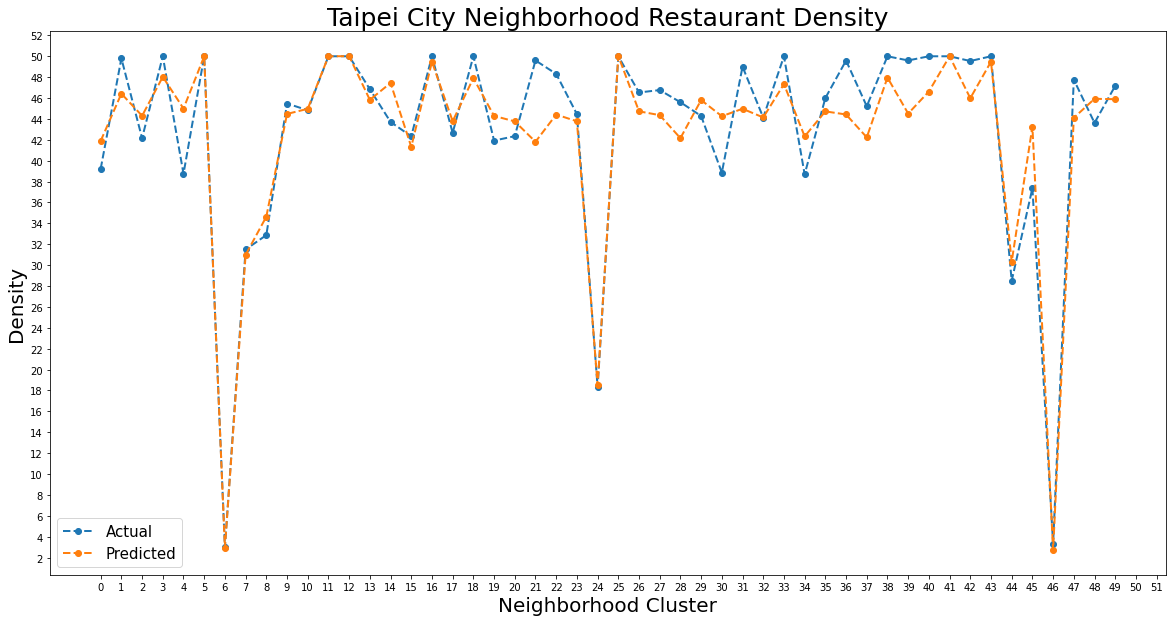

In [287]:
# graph all cluster
# plt.hist(target_df['index'], target_df['Restaurant Density'])
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Taipei City Neighborhood Restaurant Density', fontsize='25')
ax.set_xlabel('Neighborhood Cluster', fontsize='20')
ax.set_ylabel('Density', fontsize='20')
ax.set_xticks(range(0,61,1))
ax.set_yticks(range(0,61,2))
ax.plot(target_df[['Restaurant Density','Predict Density']], marker='o', linestyle='dashed',
        linewidth=2, markersize=6)
ax.legend(['Actual', 'Predicted'], loc='best', fontsize='15')


In [294]:
# We are interested in those labels whose restaurant density value is less than predicted value.
# This may indicate that local competition is less intense
# In other words, those neighborhoods could be defined as 'high-potential'
# Here we pay attention to those clusters with differences greater than 3
# restaurant_df = target_df.loc[target_df['Restaurant Density'] < target_df['Predict Density']]
restaurant_df = target_df.loc[(target_df['Predict Density'] - target_df['Restaurant Density'])>3]
potential_cluster_array = restaurant_df.index.values
restaurant_df = restaurant_df.sort_values(by=['Parent', 'IncomeMedian', 'Kid'], ascending=False)
restaurant_df

,index,Restaurant Density,Kid,Parent,Income,IncomeAvg,IncomeMedian,1stQ,3rdQ,Std,CC,Predict Density
30,Label 30,38.857143,776.142857,1559.000000,2.789779e+06,1227.285714,744.571429,405.857143,1414.714286,2326.170000,175.650000,44.262958
14,Label 14,43.714286,1051.428571,1518.285714,4.904492e+06,1856.428571,896.857143,431.714286,1848.000000,5666.997143,294.787143,47.445373
4,Label 4,38.750000,714.125000,1396.625000,3.396546e+06,1461.000000,831.375000,421.875000,1663.750000,3312.932500,206.870000,44.994428
45,Label 45,37.375000,578.250000,1268.625000,3.301493e+06,1931.875000,749.625000,393.500000,1507.500000,11026.527500,392.286250,43.263856
34,Label 34,38.700000,397.000000,891.700000,1.275558e+06,989.400000,669.500000,371.900000,1200.700000,1207.863000,119.111000,42.330518


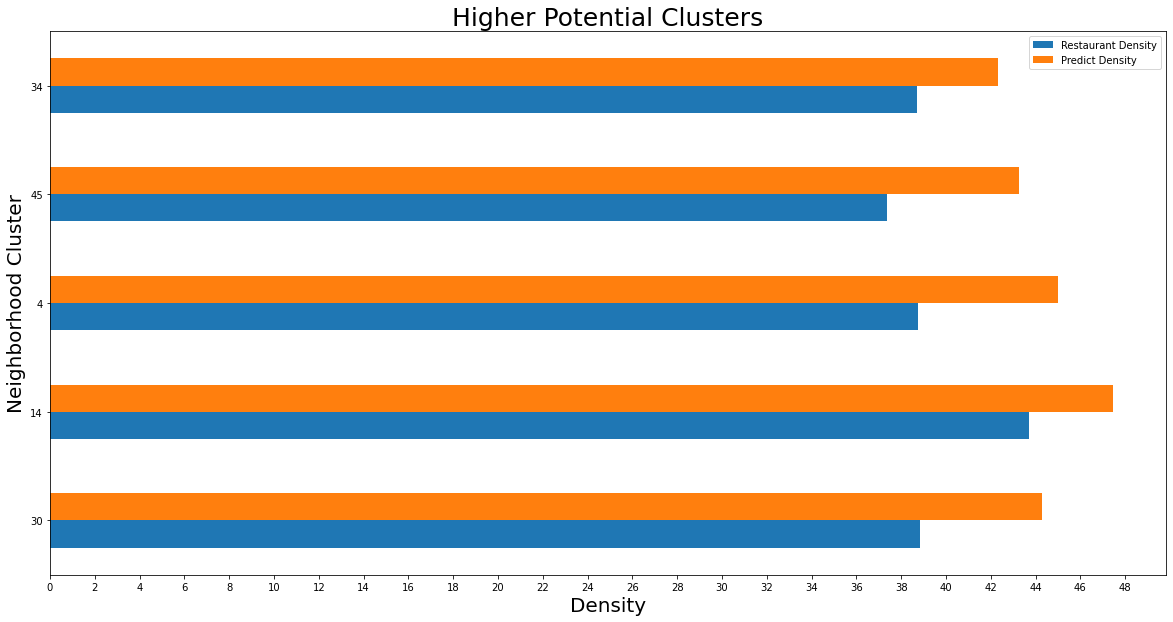

In [297]:
# graph high potential cluster
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Higher Potential Clusters', fontsize='25')
ax.set_ylabel('Neighborhood Cluster', fontsize='20')
ax.set_xlabel('Density', fontsize='20')
ax.set_xticks(range(0,60,2))
restaurant_df[['Restaurant Density','Predict Density']].plot(kind='barh', ax=ax, fontsize=10)

## 3. Data visualization

### 3.1 Visualize potential neighborhoods for catering business

In [296]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# Create a potential label map by using folium
potential_df = pd.DataFrame()
# Assign a color to each cluster
label_colors_array = cm.rainbow(np.linspace(0, 1, len(potential_cluster_array)))
label_colors={}
color_idx=0
for i in potential_cluster_array:
    potential_df = potential_df.append(tmp_df.loc[tmp_df['Label'] == i])
    label_colors[i] = colors.rgb2hex(label_colors_array[color_idx])
    color_idx+=1

# Draw the map
taipei_location = geolocator.geocode('Taipei Taiwan')
map_restaurant = folium.Map(location=[taipei_location.latitude, taipei_location.longitude], zoom_start=10)

# add markers to the map
for res, lat, lon, neighborhood, cluster in zip(potential_df['Restaurant Density'], 
                                                potential_df['Latitude'], potential_df['Longitude'], 
                                                potential_df['Neighborhood'], potential_df['Label']):
    label = folium.Popup(neighborhood + '\n Cluster ' + str(cluster) + '\n Density ' + str(res), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=label_colors[cluster],
        fill=True,
        fill_color=str(label_colors[cluster]),
        fill_opacity=0.8).add_to(map_restaurant)
       
map_restaurant